In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import numpy as np
import pandas as pd


In [3]:
import datetime as dt
from datetime import timedelta, date


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

### Precipitation Analysis


In [10]:
# create a inspector to see the columns and snapshot of data
inspector = inspect(engine)
columns = inspector.get_columns("Measurement")

# get columns in the table
print("""
Columns in Measurement table:
==============================""")
for col in columns:
    print(col["name"],col["type"])
    
# get first 5 rows of data
print("""
First 5 rows of data
==============================""")
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()





Columns in Measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

First 5 rows of data


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# latest and oldest data
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
oldest_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(f"Data is ranging from {oldest_date[0]} to {latest_date[0]}")




Data is ranging from 2010-01-01 to 2017-08-23


In [12]:
# get data from last 12 months
list_data = (session.query(Measurement.id,Measurement.station, Measurement.date,Measurement.prcp,Measurement.tobs )
         .filter(Measurement.date> '2016-08-23')
         .order_by(Measurement.date.desc()).all())

last_12months = pd.DataFrame(columns = ["id","station","date","prcp","tobs"], data = list_data)
last_12months.head()


,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.00,81.0
1,7635,USC00514830,2017-08-23,0.00,82.0
2,12187,USC00519523,2017-08-23,0.08,82.0
3,19550,USC00516128,2017-08-23,0.45,76.0
4,2723,USC00519397,2017-08-22,0.00,82.0


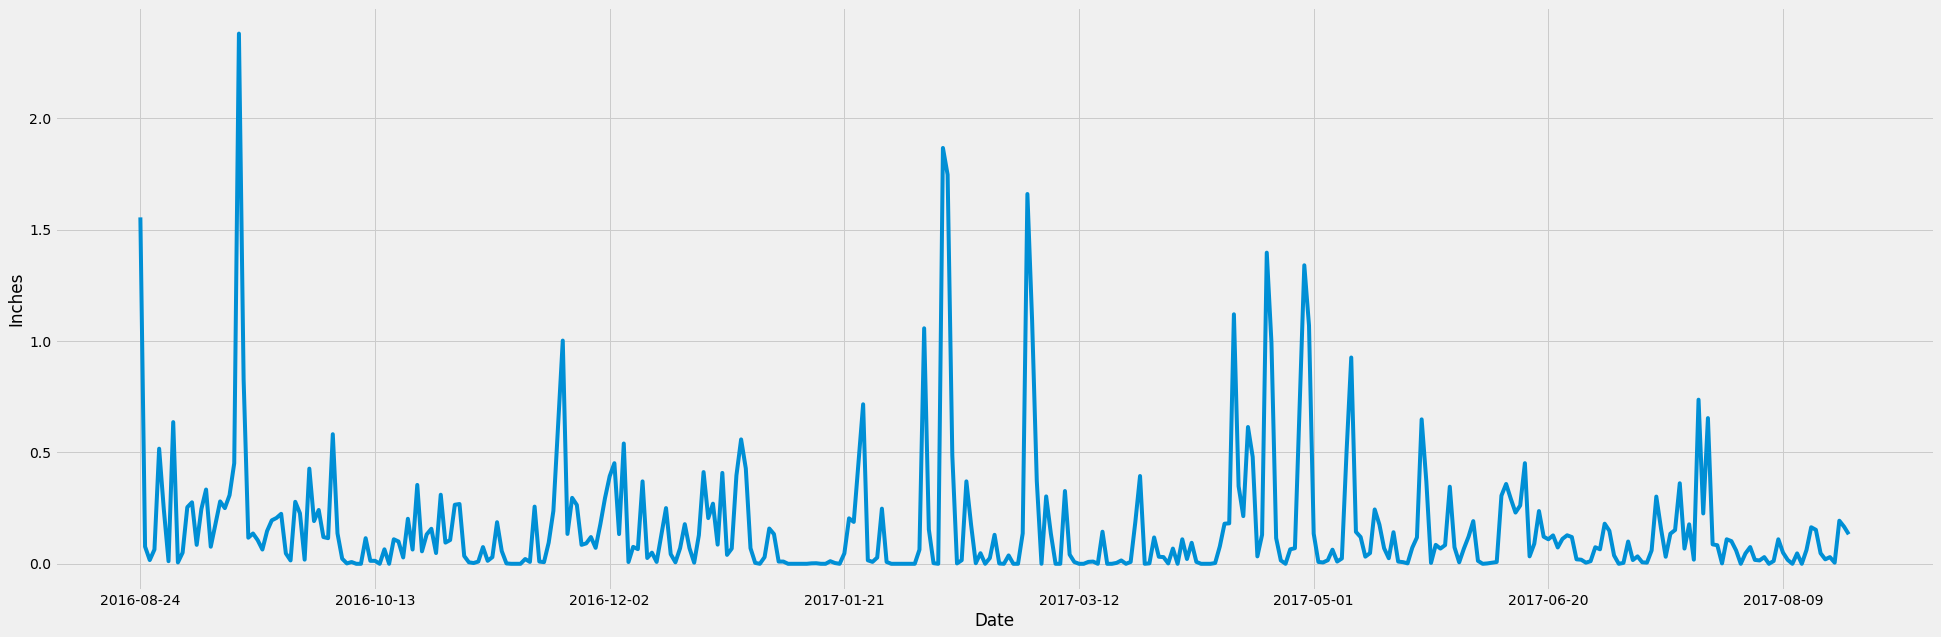

In [13]:
# plot prcp data for the last 12 months
last_12months.groupby("date").agg(precipitation =("prcp","mean")).plot(legend = False, figsize= (30,10))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12months.groupby("date").agg(precipitation =("prcp","mean")).head()


,precipitation
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [18]:
last_12months.describe()

,id,prcp,tobs
count,2223.000000,2015.000000,2223.000000
mean,10159.397211,0.176462,74.578947
std,5604.268703,0.460288,4.612232
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


### Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?
inspector = inspect(engine)
columns = inspector.get_columns("Station")

# get columns in the table
print("""
Columns in Station table:
==============================""")
for col in columns:
    print(col["name"],col["type"])
    
# get first 5 rows of data
print("""
First 5 rows of data
==============================""")
engine.execute("SELECT * FROM station LIMIT 5").fetchall()




Columns in Station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

First 5 rows of data


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [20]:
number_of_station = len(engine.execute("SELECT DISTINCT station FROM station").fetchall())
print(f"There are {number_of_station} stations in the dataset.")


There are 9 stations in the dataset.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_station_row = (engine.execute("SELECT m.station, COUNT(m.station) AS count_stations FROM measurement AS m GROUP BY station ORDER BY count_stations DESC ")
        .fetchall())
print(f"The most active station is {most_active_station_row[0][0]} with {most_active_station_row[0][1]} counts.")

# List the stations and the counts in descending order.
most_active_station_row



The most active station is USC00519281 with 2772 counts.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
content =[
    func.max(Measurement.tobs),
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs)
]
temp = session.query(*content).\
        filter(Measurement.station ==most_active_station_row[0][0]).\
        order_by(Measurement.tobs).first()

print(f"""
Temperature stats for station {most_active_station_row[0][0]}
=========================================
Average Temperature: {round(temp[2],1)}
Min Temperature: {temp[1]}
Max Temperature: {temp[0]}

""")



Temperature stats for station USC00519281
Average Temperature: 71.7
Min Temperature: 54.0
Max Temperature: 85.0




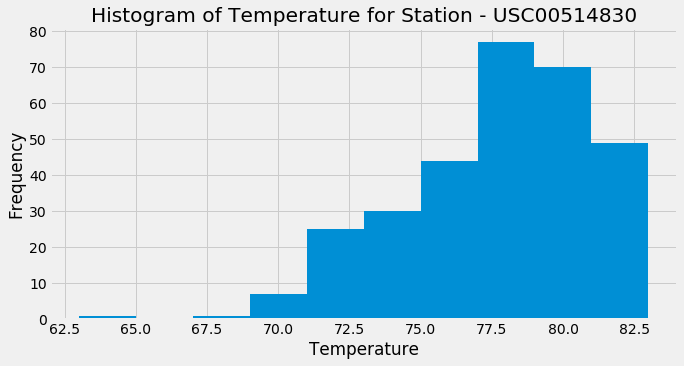

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hightest_temp_station = engine.execute("SELECT m.station, AVG(m.tobs) AS Avg_Temp FROM measurement AS m GROUP BY m.station ORDER BY Avg_Temp DESC").first()[0]
temp_data = session.query(Measurement.date,Measurement.tobs).\
                filter(Measurement.date >"2016-08-23").\
                filter(Measurement.station ==hightest_temp_station).\
                order_by(Measurement.date.desc()).all()

title = f"Histogram of Temperature for Station - {hightest_temp_station}"
temp_data_df = pd.DataFrame(columns= ["date","temperature"],data = temp_data)
temp_data_df["temperature"].plot(kind = "hist", bins = 10, figsize= (10,5), title =title)
plt.xlabel("Temperature")
plt.show()


## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))




[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps("2017-06-02","2017-06-30")



[(71.0, 77.1891891891892, 83.0)]

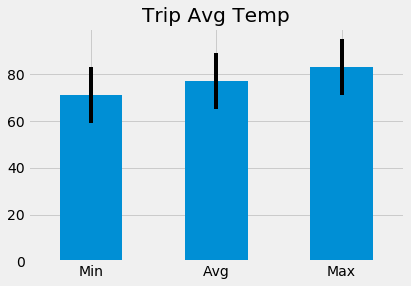

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
values= calc_temps("2017-06-02","2017-06-30")[0]
errbar = values[2]-values[0]
trip_temp = pd.DataFrame(data = {"Values":values},index = ["Min","Avg","Max"])
trip_temp.plot(kind = "bar",title = "Trip Avg Temp",yerr = errbar,legend = False,rot = 0)
plt.show()



In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
data = session.query(Measurement.station, Measurement.date,
                     Measurement.prcp,Measurement.tobs,Station.name, Station.latitude,Station.longitude, Station.elevation).\
            filter(Measurement.date>="2017-06-02").\
            filter(Measurement.date<="2017-06-30").\
            join(Station, Station.station == Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

# create dataframe
trip_data = pd.DataFrame(columns = ["station","date","prcp","tobs","name","lat","lng","elevation"],
                         data = data)
trip_data.head()





,station,date,prcp,tobs,name,lat,lng,elevation
0,USC00516128,2017-06-15,1.69,77.0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00516128,2017-06-04,0.82,77.0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00516128,2017-06-12,0.81,74.0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00516128,2017-06-14,0.81,74.0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00519281,2017-06-11,0.74,74.0,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")





[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = date(2020,6,2)
end_date = date(2020,6,30)

# Use the start and end date to create a range of dates
days_range = end_date - start_date

# Stip off the year and save a list of %m-%d strings
date_list = [str(start_date+timedelta(days = i))[5:10] for i in range(days_range.days+1)]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date)[0] for date in date_list]
normals





[(65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0),
 (67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0),
 (68.0, 74.75862068965517, 82.0),
 (69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0),
 (67.0, 75.59615384615384, 81.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(columns = ["Min","Avg","Max"],data = normals,index = date_list)
trip_dates




,Min,Avg,Max
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0
06-11,69.0,76.019608,84.0


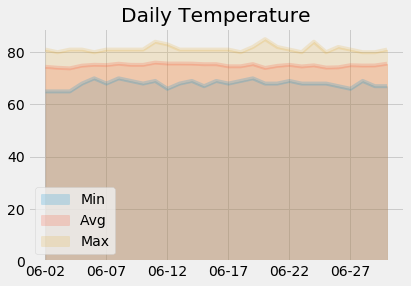

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates.plot(kind = 'area', stacked = False,x_compat=True, alpha=.2,title = "Daily Temperature")
plt.legend(loc = "best")
plt.show()

